# Table of Contents

This is copied, with some stylistic improvements, from the final project I did for STAT 6180 (Financial Time Series). In the project, I backtest the GARCH volatility framework on the S&P-500 across the most turbulent periods in recent financial history, using VaR to compare actual vs expected risk. To minimize hindsight bias, I split the data into a training and test sets, deciding on the appropriate GARCH (and ARIMA, to demean) models for the training periods only. I then iteratively forecast and update the chosen models through the crisis periods, simulating the hypothetical lived experience of a thorough risk manager. 

We find that, in the crisis periods tested, the S&P-500 was more risky than a GARCH based VaR would have predicted. Additionally, while the GARCH models generally did a good job at capturing the conditional variance during each crisis, VaR exceedances themselves appear to be clustered. This suggests that a more complicated model is needed to properly model time-varying tail risk.

* [The S&P-500](#ts5)
* [Training - Test Splits](#tts)
* [Demeaning With ARMA](#dwa)
* [GARCH](#g)
* [Iterative One-Step-Ahead Backtest](#iosab)
* [Conclusions](#c)


In [29]:
#install if needed

#!pip install sktime[all_extras]
#!pip install arch

import numpy as np
import pandas as pd
import pandas_datareader.data as web

import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

from sktime.forecasting.arima import ARIMA
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from scipy.stats import norm

from arch import arch_model

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [30]:
sp = web.DataReader("^GSPC", "yahoo", start="1/4/1954")["Adj Close"]

In [31]:
# latex string variables
epsilon = r"$\epsilon_t$"
epsilon_sq = r"$\epsilon_t^2$"
x_t = r"$X_{t}$"
z_t = r"$Z_t$"
z_t_sq = r"$Z_t^2$"
sigma_t = r"$\sigma_t$"


# utility functions
one_plus = lambda r: (r / 100) + 1
inv_one_plus = lambda r: (r - 1) * 100

# return transformations
cumulative_return = lambda r: one_plus(r).cumprod()
pct_return = lambda p: p.pct_change(1) * 100
log_price = lambda p: p.apply(np.log)
log_return = lambda p: p.apply(np.log).diff(1)

# transforming data
df = pd.DataFrame({"SP500": sp})
df["SP500 Returns"] = pct_return(df["SP500"])
df["Cumulative SP500"] = cumulative_return(df["SP500 Returns"])
df["Log Cumulative SP500"] = log_price(df["Cumulative SP500"])
df["Log Returns SP500"] = log_return(df["Cumulative SP500"]) * 100

df = df.dropna()

<a id="ts5"></a>
# The S&P-500

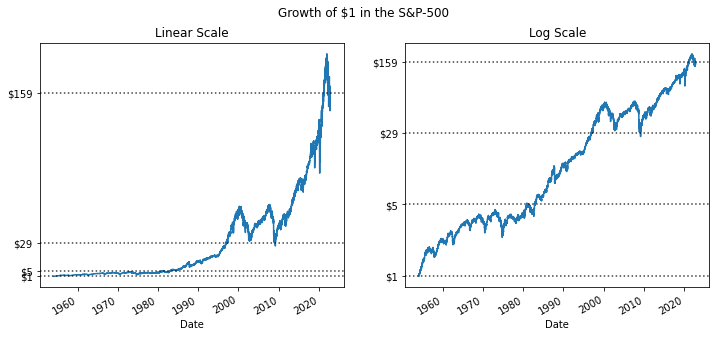

In [32]:
log_range = np.linspace(df["Log Cumulative SP500"].iloc[0], df["Log Cumulative SP500"].iloc[-1], 4)
prices = np.exp(log_range)
yticklabels = ["$" + str(round(l)) for l in prices]

f, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
f.suptitle("Growth of $1 in the S&P-500")

# linear plot
df["Cumulative SP500"].plot(ax = ax1)
ax1.set_title("Linear Scale")
ax1.set_yticks(prices)
ax1.set_yticklabels(yticklabels)

for l in prices:
    ax1.axhline(l, color = "black", linestyle = "dotted", alpha = 0.75)


# log plot

df["Log Cumulative SP500"].plot(ax = ax2)
ax2.set_yticks(log_range)
ax2.set_yticklabels(yticklabels)
ax2.set_title("Log Scale")

for l in log_range:
    ax2.axhline(l, color = "black", linestyle = "dotted", alpha = 0.75)

plt.show()

Above, we plot the S&P-500 on a normal and a log scale. While the log scale puts more emphasis on earlier price movements in comparison to more recent ones, both plots are rather miracolous. Any ordinary person who invested 1 dollar at the start of the time series would now have about 160. Since this asset tracks the largest businesses in the U.S. economy, this growth represents the growth of the American economic machne throughout the most prosperous era in history. 

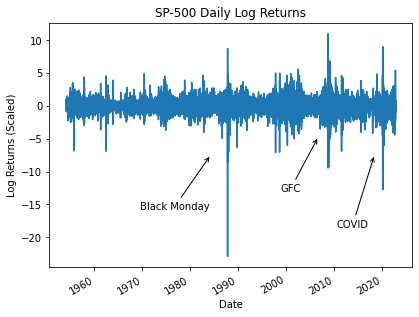

In [33]:
def annotate_wrapper(ax, text, loc_arrow, loc_text):
    ax.annotate(text, loc_arrow, loc_text, xycoords = "figure fraction", arrowprops=dict(facecolor='black', arrowstyle = "->"))
    return ax

f, ax = plt.subplots(figsize = (6.5, 5))
df["Log Returns SP500"].plot(ax = ax)
ax.set_title("SP-500 Daily Log Returns")
ax.set_ylabel("Log Returns (Scaled)")

ax = annotate_wrapper(ax,"Black Monday", (0.45, 0.45), (0.3, 0.3))
ax = annotate_wrapper(ax, "GFC", (0.68, 0.5), (0.6, 0.35))
ax = annotate_wrapper(ax, "COVID", (0.80, 0.45), (0.72, 0.25))

plt.show()

However, there is no free lunch--as economists are fond of saying. Economic theory tells us that excess return is paid for with the price of risk. Throughout the astonishing growth of the S&P-500 have been brutal drawdowns and periods of instability. I focus on three in this paper--"Black Monday", the GFC, and Covid.

Black Monday is interesting because it features the worst daily drawdown in the S&P-500--at -20%. The crisis is commonly blamed on "panic" and trading models rather than changes in the true fundamental value of the S&P-500. Because this crisis happened so quickly, it will be interesting to if GARCH is able to give any kind of forewarning.

It would be impossible to do a study on financial crisis without including the GFC. The GFC was the longest and most severe financial crisis since the Great Depression. While Black Monday may have the GFC beat on the worst day ever, the GFC had the broadest impact. 

The Covid crisis during March and April of 2020 is as severe as they come, but is more interesting as the most recent crisis period. In fact, Covid is the only financial crisis that I have clear memories of living through--though I wasn't as interested in finance then as I am now.

<a id="tts"></a>
# Training - Test Split

In this section, I simply show the training and test periods for each of the three financial crises. The training sets immediately precede the test periods, and only include about 5 years of data for numerical and relevance reasons.

In [34]:
def get_test_train(series, train_start, test_start, test_end):
    train = series.loc[(series.index >= train_start) & (series.index < test_start)]
    test = series.loc[(series.index >= test_start) & (series.index <= test_end)]
    return train, test, pd.concat([train, test], axis = 0)

def train_test_plot(train, test, name):

    f, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
    f.suptitle(name)
    ax1.set_title("Training vs Test Sets")
    train.plot(color = "tab:blue", label = "Training Set", ax = ax1, alpha = 0.5)
    test.plot(color = "tab:blue", label = "Test Set", ax = ax1)

    ax2.set_title("Test Set Zoomed In")
    test.plot(ax = ax2)

    ax1.legend()
    ax1.set_ylabel("Daily Log Returns (Scaled)")
    plt.show()

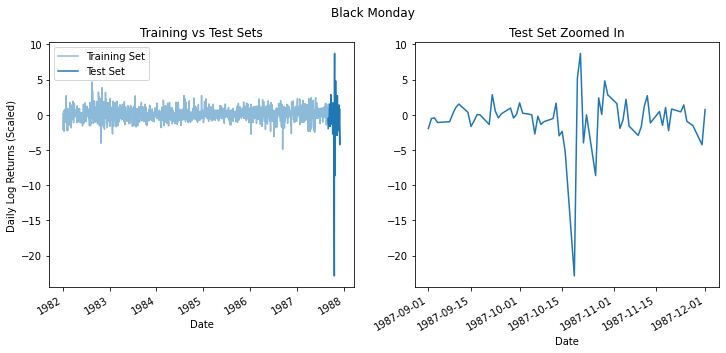

In [124]:
bm_splits = get_test_train(df["Log Returns SP500"], "1982", "1987-09","1987-12")
bm_train, bm_test, bm_full = bm_splits

train_test_plot(bm_train, bm_test, "Black Monday")

With the zoomed in line plot, it is clear that the main drawdown isn't preceded by a noticeable increase in volatility. It will be interesting to see what the GARCH model tells us here.

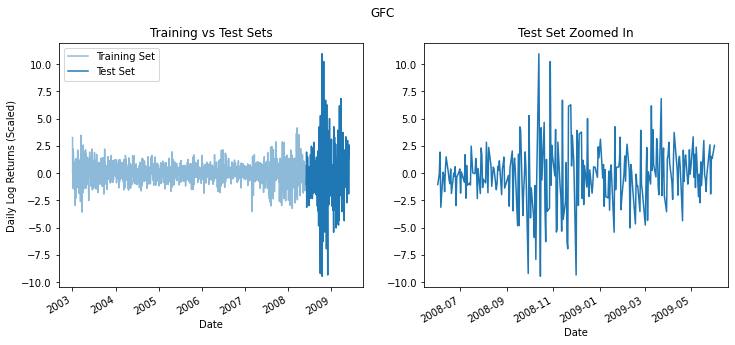

In [123]:
gfc_splits = get_test_train(df["Log Returns SP500"], "2003", "2008-06", "2009-06")
gfc_train, gfc_test, gfc_full = gfc_splits

train_test_plot(gfc_train, gfc_test, "GFC")

The GFC was a slower moving crisis. This would seem to be the ideal scenario for GARCH, as the model would have ample time to respond (and then mitigate) the dynamic volatility.

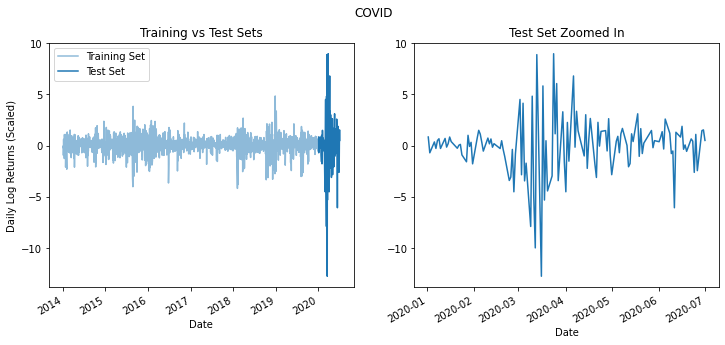

In [122]:
splits = get_test_train(df["Log Returns SP500"], "2014", "2020-01", "2020-07")
covid_train, covid_test, covid_full = splits

train_test_plot(covid_train, covid_test, "COVID")

I incluced the first half of 2020 in this plot, but the crisis is mostly contained to March and April of 2020. If I remember correctly, the S&P-500 had a circuit breaker shut down 4 times during March of 2020.

<a id="dwa"></a>
# Demeaning With ARMA

Before we can fit a GARCH volatility model to the data, we must remove any mean process. This can be done with ARMA. The market efficiency hypothesis and common sense tells us that there shouldn't be a conditional mean process at work with financial data, but we do find serial correlation in all three of the training periods. This is an interesting result that should be explored and tested in further research--for our purposes here we are content to simple remove the conditional mean through ARMA.

In its most intuitive form, the ARMA equation is:

$$X_t = ARMA(p, q) = \mu + \sum_{i = 1}^{p}\phi_iX_{t-i} +\sum_{j = 1}^{q}\theta_jZ_{t-j} + Z_t$$
$$Z_t \sim WN(0, \sigma^2)$$

That is, we model $X_t$ as a linear combination of past values of $X_t$ and the white noise process $Z_t$. The primary choices we face when constructing ARMA models is $p$ and $q$--how many past lags of $X_t$ and $Z_t$ to include, respectively. The corresponding estimated parameters are the $\phi$s and $\theta$s.

Note that here we only fit ARMA models to the training data. These models are iteratively updated through the test set, but we only use the training data to make choices about $p$ and $q$.

In [96]:
def get_ljung_box(x, lags):
    return acorr_ljungbox(x, lags = lags).iloc[-1]["lb_pvalue"]

def get_acf_table(y, lags = 30, partial = False, alpha = 0.05):
    if partial is False:
        coef, conf = acf(y, nlags = lags, fft=True, alpha = alpha)
    else:
        coef, conf = pacf(y, nlags = lags, alpha = alpha)
        
    table = pd.DataFrame({"coef": coef, "lower": conf[:, 0], "upper": conf[:, 1]})
    table["significant"] = (table["lower"] * table["upper"]) > 0
    table["upper diff"] = table["upper"] - table["coef"]
    table["lower diff"] = table["lower"] - table["coef"]
    
    p = get_ljung_box(y, lags = lags)
    return table, p
    

def acf_plot(acf_table, ljung_box_p, name, ax = None):
    if ax is None:
        f, ax = plt.subplots(figsize=(7, 4))

    lag_range = acf_table.index
    for lag in lag_range:
        coef = acf_table['coef'].iloc[lag]
        ax.plot([lag, lag], [0, coef], color = "black", lw = 2)

    ax.fill_between(lag_range, acf_table["upper diff"], acf_table["lower diff"], alpha = 0.4, label = "95% Confidence Interval")
    ax.axhline(0, linestyle = "dashed", lw = 1, color = "black")

   
    ax.plot([], [], label = "Ljung Box P-Value: " + str(round(ljung_box_p, 3)), alpha = 0)

    ax.set_title(name)
    ax.set_xlabel("Lag")
    ax.legend(bbox_to_anchor = (1, 1))

    
def fit_mean_model(y, order):
    y_index = y.index

    y.index = pd.RangeIndex(0, y.shape[0])
    fh = np.arange(-(y.shape[0] - 1), 1)
    
    mean_model = ARIMA(order = order).fit(y)
    pred = mean_model.predict(fh = fh)

    y.index = y_index
    pred.index = y_index
    
    return {
        "Model": mean_model,
        "Pred": pred,
        "Resid": y - pred   
    }


def before_after_acf(y_before, y_after, crisis_name, is_mean_model = True):
    
    if is_mean_model:
        model_string = "ARIMA"
        input_string = x_t
        resid_string = z_t
    else:
        model_string = "GARCH"
        input_string = z_t_sq
        resid_string = epsilon_sq
        
        y_before = y_before ** 2
        y_after = y_after ** 2
        
    plot_name = crisis_name + " Train " + model_string + " ACFs"
    
    f, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12.5, 4.5))
    f.suptitle(plot_name)
    
    acf_plot(*get_acf_table(y_before), input_string, ax = ax1)
    acf_plot(*get_acf_table(y_after), resid_string, ax = ax2)

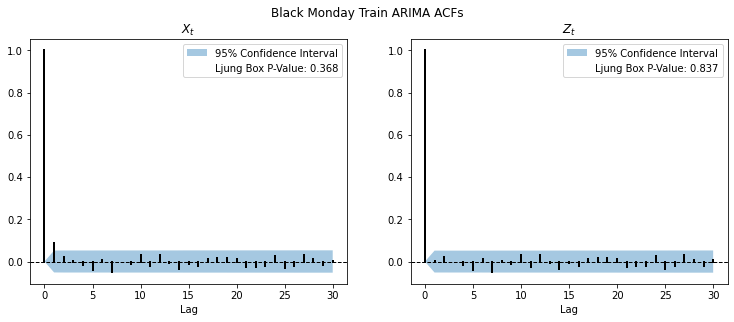

In [98]:
bm_mean_results = fit_mean_model(bm_train, (0, 0, 1))

before_after_acf(bm_train, bm_mean_results["Resid"],"Black Monday")

The ACF is a key tool to help us decide if there is serial correlation in the data, and if so, how we might go about modeling them. In the ACF plot on the left, the first lag has a statistically significant correlation for the Black Monday Training data. This indicates that an MA(1) model is appropriate. On the left is the ACF of the white noise $Z_t$ term. We want this to have no serial correlation, which is shown by the highly insignificant p-value. (The begining Ljung Box p-value is also insigificant, but I remove the significant first lag to be extra careful).

In [92]:
print(bm_mean_results["Model"].summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1432
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -1869.002
Date:                Thu, 17 Nov 2022   AIC                           3744.004
Time:                        08:26:08   BIC                           3759.805
Sample:                             0   HQIC                          3749.904
                               - 1432                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0692      0.026      2.705      0.007       0.019       0.119
ma.L1          0.0831      0.025      3.356      0.001       0.035       0.132
sigma2         0.7965      0.021     37.522      0.0

A closer look at the summary of the MA(1) model confirms that the lag1 MA term is indeed highly significant.

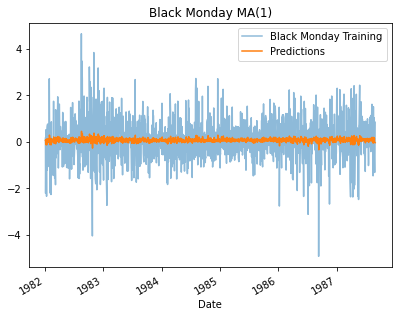

In [93]:
f, ax = plt.subplots(figsize = (6.5, 5))
ax.set_title("Black Monday MA(1)")
bm_train.plot(alpha = 0.5, label = "Black Monday Training")
bm_mean_results["Pred"].plot(label = 'Predictions')
ax.legend()
plt.show()

While significant, the predictive effect of the MA(1) model is extremely small.

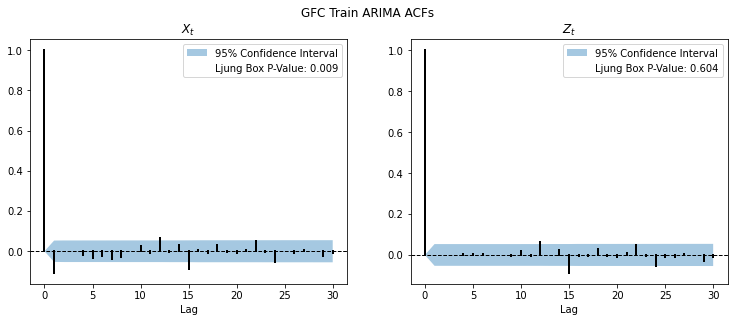

In [99]:
gfc_mean_results = fit_mean_model(gfc_train, (8, 0, 0))

before_after_acf(gfc_train, gfc_mean_results["Resid"], "GFC")

For the GFC training period, we have another ACF strucure entirely. This time the overall Ljung-Box is significant, but the first lag now has a negative autocorrelation. The 15th lag also appears to be significant. While we could model this using an MA model, I used an ARMA(8, 0) model as the quick and dirty solution. It gets at what we need--removing enough of the autocorrelation--and appears to be significantly faster than a similarly complex ARMA(0, 8) model or mixed ARMA model. This matters quite a bit, as we will be refitting this model over 300 times--each day of the year long GFC test set.

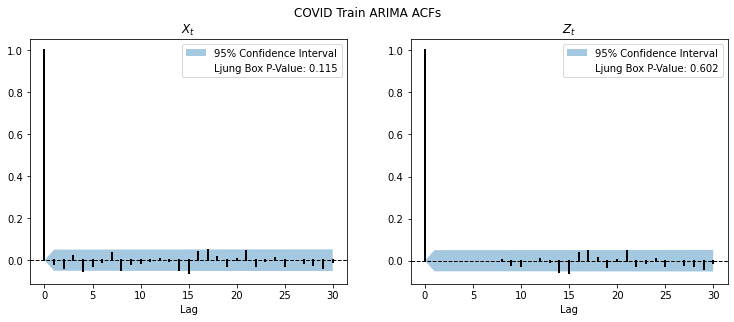

In [100]:
covid_mean_results = fit_mean_model(covid_train, (8, 0, 0))
before_after_acf(covid_train, covid_mean_results["Resid"], "COVID")

The most recent ACF (the Covid training period) looks the best, but it does have a more significant Ljung Box p-value than the Black Monday training period. To boost the $Z_t$ Ljung-Box and to match the GFC training model, I also used an ARMA(8, 0) here.

<a id="g"></a>
# GARCH

It is shown in the previous section that ARMA models help us analyze the conditional mean of $X_t$. The GARCH family of models builds on the ARMA framework by helping us analyze the conditional variance of $Z_t$. While white noise processes are not linearly correlated, they are allowed to have other forms of linear dependence. In fact, $Z_t^2$ is often found to have significant linear correlations. That is, the variance of $Z_t$ is often serially correlated. To start the GARCH equations, we model $Z_t$ as a function of a time varying scaling factor $\sigma_t$ and $\epsilon_t$--an i.i.d process.

$$Z_t = \sigma_t\epsilon_t$$
$$\epsilon_t \sim i.i.d$$

While we assume $\epsilon_t$ is i.i.d. we have not given it a specific distribution. This can be chosen by the analyst when modeling specific data, and is not essential for the equations here. We then model $\sigma_t^2$ as follows:

$$\sigma^2_t = \alpha_0 + \sum_{i = 1}^{p}\alpha_iZ_{t-i}^2 + \sum_{j = 1}^{q}\beta_j\sigma_{t-j}^2$$

Like ARMA, the GARCH predicted variance is a linear combination of itself and a term with an error past lags. In practice GARCH(1,1) is often sufficient for many problems.

In [118]:
def fit_vol_model(y, model_params, train_test_split = None):
    model = arch_model(y, **model_params)
    
    fitted = model.fit(disp = "off")
    train_y = y
        
    train_pred = fitted.conditional_volatility.dropna()
    train_resid = fitted.resid / train_pred
    
    return {
        "Train Y": train_y,
        "Pred": train_pred,
        "Resid": train_resid,
        "Fitted": fitted,
        "Model": model
    }

def vol_resid_plots(returns, pred_vol, resid, crisis_name, is_train = True):
    f_name = crisis_name + " GARCH(1, 1) " + "Training" if is_train else crisis_name + " Iterative Forecasts"
    
    f, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
    f.suptitle(f_name)
    returns.plot(ax = ax1, label = z_t, alpha = 0.5)
    pred_vol.plot(ax = ax1, label = sigma_t, lw = 2)
    ax1.legend()
    ax1.set_title(z_t + "  and  " + sigma_t)
    
    if not is_train:
        p = get_ljung_box(resid ** 2, lags = 30)
        p_string = " (Ljung Box P-Value of " + epsilon_sq + " : " + str(round(p, 3)) + ")"
    else:
        p_string = ""
    
    resid.plot(ax = ax2, label = epsilon)
    ax2.set_title(epsilon + p_string)
    ax2.legend()
    
garch_params = {"p": 1, "q": 1, "vol": "Garch", "dist": "skewt"}

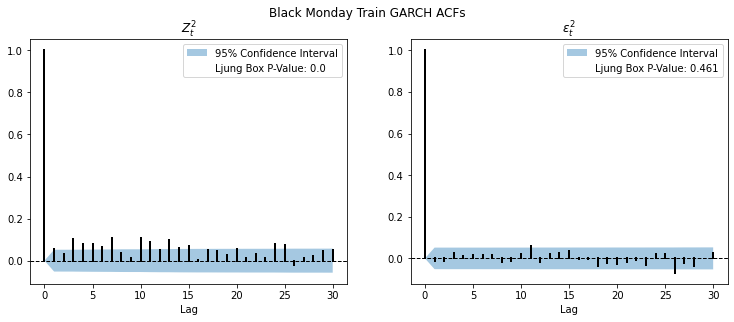

In [119]:
bm_vol_results = fit_vol_model(bm_train_resid, garch_params)

before_after_acf(bm_train, bm_vol_results["Resid"], 
                 "Black Monday", is_mean_model = False)

$Z_t^2$ turns out to have highly significant serial correlations. As with the rest of the demeaned training data, a GARCH(1, 1) model is sufficient to remove the conditional variance, as shown in the Ljung Box p-values. 

Note that I specify a skewed t distribution for all the GARCH models. It can be shown that the skew parameters are signficant, though I don't include that analysis here. 

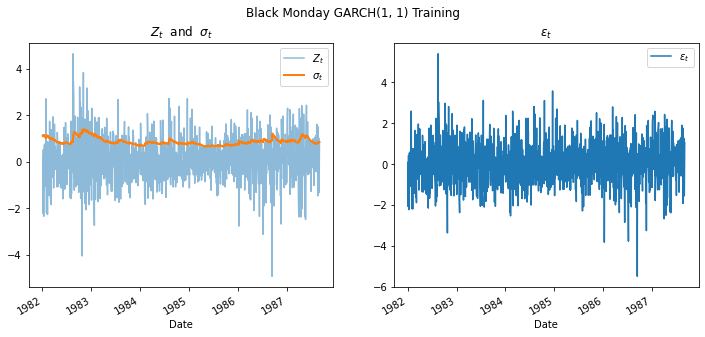

In [110]:
vol_resid_plots(bm_train, bm_vol_results["Pred"], 
                bm_vol_results["Resid"], "Black Monday")

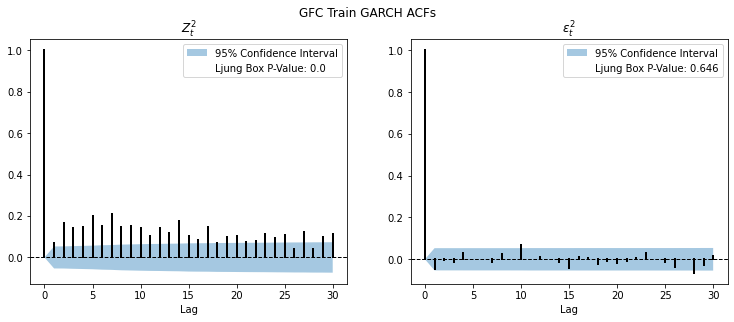

In [111]:
gfc_vol_results = fit_vol_model(gfc_train_resid, garch_params)

before_after_acf(gfc_train, gfc_vol_results["Resid"], 
                 "GFC", is_mean_model = False)

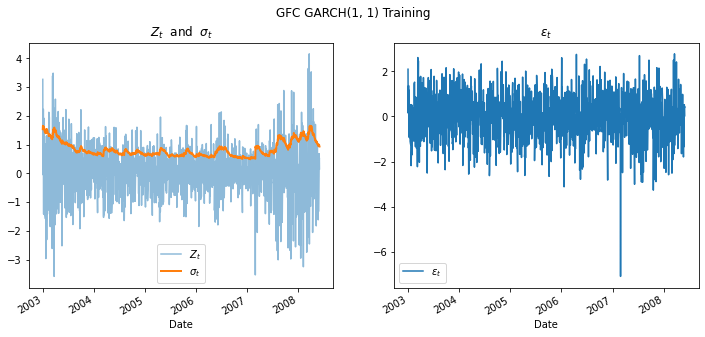

In [112]:
vol_resid_plots(gfc_train, gfc_vol_results["Pred"], 
                gfc_vol_results["Resid"], "GFC")

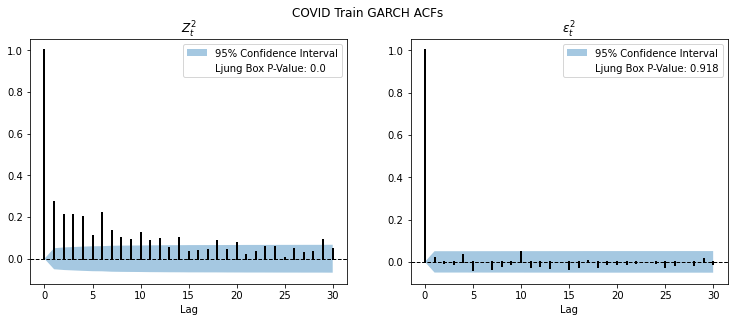

In [116]:
covid_vol_results = fit_vol_model(covid_train_resid, garch_params)

before_after_acf(covid_train, covid_vol_results["Resid"], 
                 "COVID", is_mean_model = False)

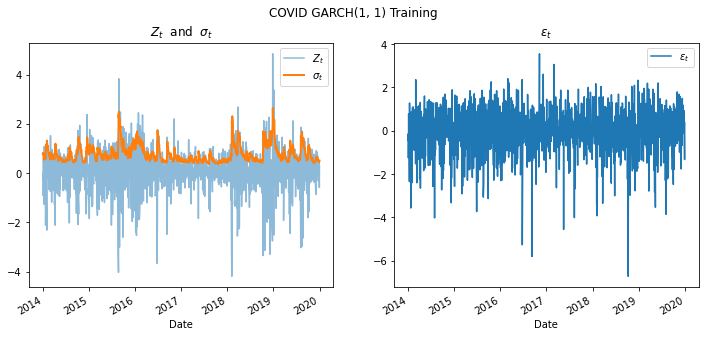

In [117]:
vol_resid_plots(covid_train, covid_vol_results["Pred"], 
                covid_vol_results["Resid"], "COVID")

<a id="iosab"></a>
# Iterative One-Step-Ahead Backtest

To ensure a realistic backtest, for each day during each test set I refit the respective ARMA and GARCH models and make a prediction for the next day. This is quite computationally expensive, especially for the GFC period, where the test set is nearly a year long. 

In [120]:
def backtest_model(mean_model_obj, vol_model_params, full, test, train_demeaned):

    # set up
    full_length = full.shape[0]; test_length = test.shape[0]; train_length = train_demeaned.shape[0]

    # new index
    full.index = pd.RangeIndex(0, full_length)

    splitter = ExpandingWindowSplitter(initial_window = train_length, fh = [1], step_length=1)

    # mean model backtest
    eval_df = evaluate(forecaster=mean_model_obj, y = full, cv = splitter, return_data=True, strategy="refit")

    pred = np.array([eval_df["y_pred"].iloc[x].iloc[-1] for x in range(test_length)])
    true = np.array([eval_df["y_test"].iloc[x].iloc[-1] for x in range(test_length)])

    test_demeaned = pd.Series(true - pred, index = test.index)
    full_demeaned = pd.concat([train_demeaned, test_demeaned])

    date_index = full_demeaned.index
    full_demeaned.index = pd.RangeIndex(0, train_length + test_length)

    # vol model backtesting
    variance_forecasts = []
    q_forecasts = []
    for train, fh in splitter.split(full_demeaned):
        
        # fitting new model
        new_model = arch_model(full_demeaned.iloc[train], **vol_model_params)
        new_fit = new_model.fit(disp="off")
        
        # variance forecast
        variance = new_fit.forecast(horizon = 1, reindex=False).variance ** 0.5
        variance_forecasts.append(variance.iloc[0]["h.1"])
        
        # q forecast
        q = new_model.distribution.ppf(0.05, new_fit.params[["eta", "lambda"]].values)
        q_forecasts.append(q)

    full_demeaned.index = date_index
    variance_forecasts = pd.Series(variance_forecasts, index = test.index)
    q_forecasts = pd.Series(q_forecasts, index = test.index)
    
    return {
        "Full Demeamed": full_demeaned,
        "Test Demeaned": test_demeaned,
        "Volatility Forecasts": variance_forecasts,
        "Q Forecasts": q_forecasts,
        "Test Vol Resid": test_demeaned / variance_forecasts
        
    }


def plot_model_vol(test_y, model_forecasts, cr, loc = "lower left"):
    f, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (7, 5))
    
    test_y.plot(alpha = 0.5, label = z_t, ax = ax1)
    model_forecasts.plot(ax = ax1, label = sigma_t, lw = 2.2)

    ax.set_title(name)
    ax.legend(loc = loc)
    
    f, ax = plt.subplots()
    resid.plot()
    ax.set_title(epsilon)
    plt.show()
    
    p = get_ljung_box(resid ** 2, lags = 30)
    print("Ljung Box P-Value of " + epsilon_sq + " : " + str(round(p, 3)))



def plot_var(test, q_forecasts, vol_forecasts, name, loc = "lower left"):

    var = q_forecasts * vol_forecasts
    
    f, ax = plt.subplots(figsize = (6.5, 5))
    ax.set_title(name)
    test.plot(alpha = 0.5, label = "")
    var.plot(color = "black", label = "95% VaR Forecast")

    beyond_var = test[test < var]
    ax.scatter(beyond_var.index, beyond_var, label = "< 95% VaR", color = "red")
    ax.legend(loc = loc)
    percent_beyond = (len(beyond_var) / len(test)) * 100
    
    plt.show()
    
    print("% Below VaR Forecast: ", str(round(percent_beyond, 3)) + "%")
    

In [83]:
bm_results = backtest_model(bm_mean_model, 
                            garch_params, 
                            bm_full, 
                            bm_test, 
                            bm_train_resid)

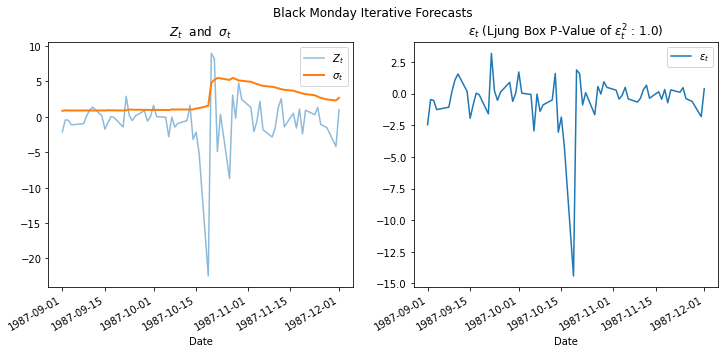

In [85]:
vol_resid_plots(bm_results["Test Demeaned"], 
                bm_results["Volatility Forecasts"], 
                bm_results["Test Vol Resid"], 
                "Black Monday", is_train = False)

While the volatilty forecasts are completely blinsided by the massive Black Monday drawdown, the model suceeds in removing the volatility that followed. Also, the forecasts suceed in removing serial variance--the Ljung Box p-value is highly insignificant at 1.

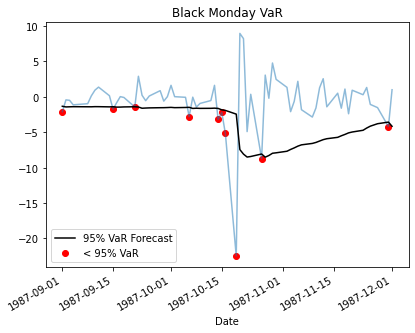

% Below VaR Forecast:  15.625%


In [75]:
plot_var(bm_results["Test Demeaned"], 
         bm_results["Q Forecasts"], 
         bm_results["Volatility Forecasts"], 
         "Black Monday VaR")

The narrative is complicated when the volatility forecasts are translated into VaR numbers using the $\epsilon_t$ skewed t distribution. One problem is that (95%) VaR exceedances are more common than the predicted 5%--nearly 16% of observations are lower than the VaR forecasts. More problematic is the clustering of these VaR exceedances. Ominously, we see several VaR exceedances right before the massive 20% drawdown. 

In [76]:
gfc_results = backtest_model(gfc_mean_model, 
                             garch_params, 
                             gfc_full, 
                             gfc_test, 
                             gfc_train_resid)

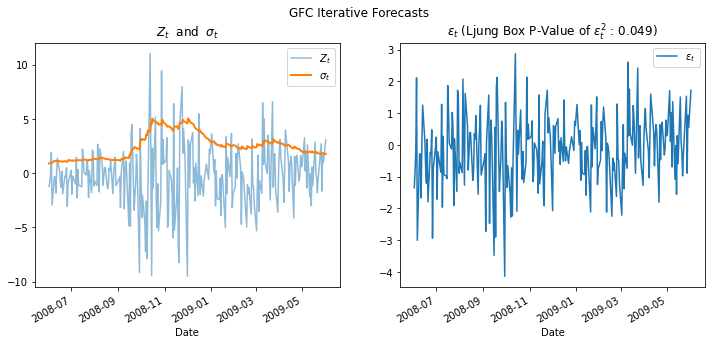

In [78]:
vol_resid_plots(gfc_results["Test Demeaned"], 
                gfc_results["Volatility Forecasts"], 
                gfc_results["Test Vol Resid"], 
                "GFC", is_train = False)

Visually, the GFC performance seems quite good. However, the Ljung-Box test on $\epsilon_t^2$ tells a different story--the GARCH model doesn't appear to be removing all the conditional variance. This should be understood as a feature of the crisis rather than a modeling deficiency--we specifically didn't choice the GARCH order using the test periods.

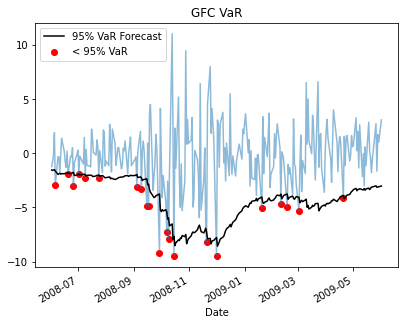

% Below VaR Forecast:  8.333%


In [79]:
plot_var(gfc_results["Test Demeaned"], 
         gfc_results["Q Forecasts"], 
         gfc_results["Volatility Forecasts"], 
         "GFC VaR", loc = "upper left")

Interestingly, the VaR situation isn't as bad as Black Monday. The test data only exceeded the VaR forecasts 8% of the time, down 1/2 from the 15% of Black Monday. While the GFC featured more frequent negative returns than Black Monday, it appears that the GARCH model was better able to adapt to the slower moving GFC.

In [80]:
covid_results = backtest_model(covid_mean_model, 
                               garch_params, 
                               covid_full, 
                               covid_test, 
                               covid_train_resid)

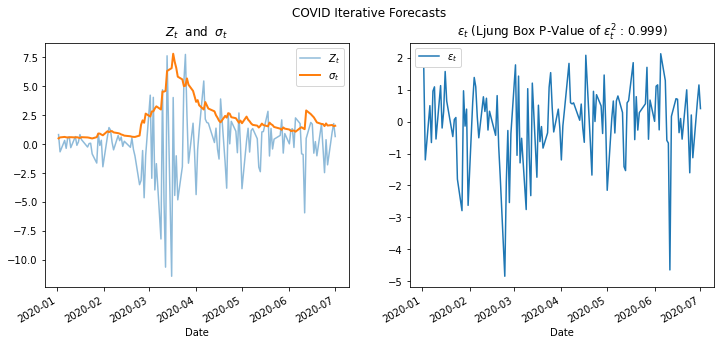

In [81]:
vol_resid_plots(covid_results["Test Demeaned"], 
                covid_results["Volatility Forecasts"], 
                covid_results["Test Vol Resid"], 
                "COVID", is_train = False)

The Covid forecasts look good visually (like the GFC) and show a highly insignificant p-value (like Black Monday). 

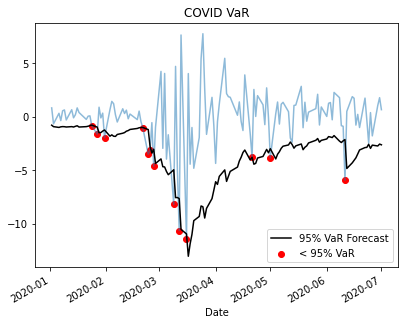

% Below VaR Forecast:  10.317%


In [82]:
plot_var(covid_results["Test Demeaned"], 
         covid_results["Q Forecasts"], 
         covid_results["Volatility Forecasts"], 
         "COVID VaR", loc = "lower right")

The VaR results look worse than the GFC but better than Black Monday. We still have twice as many VaR exceedances than predicted (10% vs 5%), though, and they also appear to be clustered. March, indeed, was a rough month.

<a id="c"></a>
# Conclusions

For all three crisis periods, the S&P-500 was more risky than a diligent risk manager would have predicted using GARCH. However, this disparity varies quite significantly from crisis to crisis. While the GARCH models were able to capture the serial correlation for Black Monday and COVID, it appears that VaR exceedances exhibit serial correlation. These issues can be interpreted as either a problem with the GARCH model, a product of just how extreme the conditions were, or both. 

Additionally, this notebook opens further questions about the signifcant autocorrelations discovered during the ARMA modeling step. How robust are these autocorrelations? Can/Could one profit from these anomolies? 